# Race/Census Tract Clean up and Introducing CalEnviroScreen and R
Looking again at CalEnviroscreen, this time through the CSV rather than the shapefile data.

In [ ]:
## Importing mapping tools and datasets 

In [13]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import contextily as ctx
import branca.colormap as cm

In [ ]:
Read the files (ACS CT data), converting FIPS to str to allow for some of the merging later on, and only keep relevant columns only 

In [16]:
# Load census tract data as we decided to retain the race/ethnicity and income related CT data (deprioritizing education, home values, and disability) 
CT = pd.read_csv('Data/ACS_2022_Race_5YEst.csv',
                       dtype= {'FIPS':str,
                              'Census Tract': str})
CT.columns
columns_to_keep = ['Census Tract',
                   'FIPS',
                   'Population Density (Per Sq. Mile)',
                   'Total Population:',
                   'Total Population: Hispanic or Latino',
                   'Total Population: Not Hispanic or Latino: White Alone',
                   'Total Population: Not Hispanic or Latino: Black or African American Alone',
                   'Total Population: Not Hispanic or Latino: Asian Alone',
                   'Total Population: Not Hispanic or Latino: Native Hawaiian and Other Pacific Islander Alone',
                   'Owner Occupied Housing Units',
                   'Owner Occupied Housing Units: Non-White Homeowners']
                 
CT2= CT[columns_to_keep]
CT2.info

<bound method DataFrame.info of      Census Tract         FIPS  Population Density (Per Sq. Mile)  \
0          101110  06037101110                           9100.317   
1          101122  06037101122                           4078.868   
2          101220  06037101220                          12900.170   
3          101221  06037101221                          27466.400   
4          101222  06037101222                          24527.460   
...           ...          ...                                ...   
2493       980038  06037980038                              0.000   
2494       980039  06037980039                              0.000   
2495       990100  06037990100                                NaN   
2496       990200  06037990200                                NaN   
2497       990300  06037990300                                NaN   

      Total Population:  Total Population: Hispanic or Latino  \
0                  4014                                  1082   
1        

In [ ]:
Command pandas to read the file and converted a few of the location variables to strings for subsequent analysis (e.g., merging datasets)

In [18]:
CES_df = pd.read_excel('Data/Calenviroscreen4.xlsx',
    dtype=
    {
        'Census Tract':str,
        'California County':str,
        'Approximate Location': str
    }
)
columns_to_keep2 = ['Census Tract',
                   'California County',
                   'Approximate Location',
                   'Longitude',
                   'Latitude',
                   'CES 4.0 Score',
                   'CES 4.0 Percentile',
                   'CES 4.0 Percentile Range',
                   'Poverty Pctl',
                   'Unemployment Pctl']
                 
CES_df= CES_df[columns_to_keep2]
CES_df.info

<bound method DataFrame.info of      Census Tract California County                 Approximate Location  \
0      6019001100            Fresno                               Fresno   
1      6077000700       San Joaquin                             Stockton   
2      6037204920       Los Angeles                          Los Angeles   
3      6019000700            Fresno                               Fresno   
4      6019000200            Fresno                               Fresno   
...           ...               ...                                  ...   
8030   6107004000            Tulare                          Porterville   
8031   6109985202          Tuolumne  Unincorporated Tuolumne County area   
8032   6111001206           Ventura   Unincorporated Ventura County area   
8033   6111003012           Ventura                               Oxnard   
8034   6111980000           Ventura   Unincorporated Ventura County area   

       Longitude   Latitude  CES 4.0 Score  CES 4.0 Per

In [ ]:
However, we notice that there is no 0 infront of the census tract, uze zfill function 

In [19]:
#z-fill function 
CES_df['Census Tract'] = CES_df['Census Tract'].str.zfill(11)

In [20]:
#rename the 'Census Tract' column to FIPS for uniformity and merging 
CES_df.rename(columns={'Census Tract': 'FIPS'}, inplace=True)

In [21]:
#verify column name change 
CES_df.info

<bound method DataFrame.info of              FIPS California County                 Approximate Location  \
0     06019001100            Fresno                               Fresno   
1     06077000700       San Joaquin                             Stockton   
2     06037204920       Los Angeles                          Los Angeles   
3     06019000700            Fresno                               Fresno   
4     06019000200            Fresno                               Fresno   
...           ...               ...                                  ...   
8030  06107004000            Tulare                          Porterville   
8031  06109985202          Tuolumne  Unincorporated Tuolumne County area   
8032  06111001206           Ventura   Unincorporated Ventura County area   
8033  06111003012           Ventura                               Oxnard   
8034  06111980000           Ventura   Unincorporated Ventura County area   

       Longitude   Latitude  CES 4.0 Score  CES 4.0 Per

In [22]:
# add geo qualities to the race-focused census tract data  
tracts = gpd.read_file('Data/Census_Tracts_2020_DM.geojson')

In [23]:
# Name one column 'FIPS' 
tracts['FIPS'] = '06'+ '037' + tracts['CT20']
tracts.head()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,FIPS
0,1,101110,1011.10,1.229562e+07,15083.854287,"POLYGON ((-118.28491 34.25948, -118.28492 34.2...",06037101110
1,2,101122,1011.22,2.845774e+07,31671.455844,"POLYGON ((-118.29015 34.27417, -118.29015 34.2...",06037101122
2,3,101220,1012.20,7.522093e+06,12698.783810,"POLYGON ((-118.28100 34.25592, -118.28198 34.2...",06037101220
3,4,101221,1012.21,3.812000e+06,9161.710543,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",06037101221
4,5,101222,1012.22,3.191371e+06,9980.600461,"POLYGON ((-118.28594 34.25405, -118.28594 34.2...",06037101222


In [ ]:
We will now join the tracts and CT datasets to retrieve geometry data

In [24]:
# Add the geometries (tracts) to the census tract race data (CT2)
CT_geo = pd.merge(CT2, tracts, on='FIPS', how='left')
# check the dataset [result: there is 400+ no match values)
CT_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 17 columns):
 #   Column                                                                                      Non-Null Count  Dtype   
---  ------                                                                                      --------------  -----   
 0   Census Tract                                                                                2498 non-null   object  
 1   FIPS                                                                                        2498 non-null   object  
 2   Population Density (Per Sq. Mile)                                                           2495 non-null   float64 
 3   Total Population:                                                                           2498 non-null   int64   
 4   Total Population: Hispanic or Latino                                                        2498 non-null   int64   
 5   Total Population: Not Hispanic or 

In [25]:
# Check the shape of the CT_geo and CT2 [result: CT_geo has same number of rows as CT2 plus 7 columns from tracts dataset]
CT_geo.shape
CT2.shape

(2498, 11)

In [26]:
# Finally we can merge the CT_geo data and the Cal Enviro data. But first, let's narrow the CalEnviro data to the Los Angeles County 
CES_LA = CES_df[CES_df['California County'] == 'Los Angeles']
CES_LA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2343 entries, 2 to 7990
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FIPS                      2343 non-null   object 
 1   California County         2343 non-null   object 
 2   Approximate Location      2343 non-null   object 
 3   Longitude                 2343 non-null   float64
 4   Latitude                  2343 non-null   float64
 5   CES 4.0 Score             2297 non-null   float64
 6   CES 4.0 Percentile        2297 non-null   float64
 7   CES 4.0 Percentile Range  2297 non-null   object 
 8   Poverty Pctl              2305 non-null   float64
 9   Unemployment Pctl         2263 non-null   float64
dtypes: float64(6), object(4)
memory usage: 201.4+ KB


In [27]:
# combine Cal Enviro data (CES) and the census tract data with geometry (CT_geo)
CES_tracts = CT_geo.merge(CES_LA, on='FIPS')
CES_tracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 26 columns):
 #   Column                                                                                      Non-Null Count  Dtype   
---  ------                                                                                      --------------  -----   
 0   Census Tract                                                                                2018 non-null   object  
 1   FIPS                                                                                        2018 non-null   object  
 2   Population Density (Per Sq. Mile)                                                           2018 non-null   float64 
 3   Total Population:                                                                           2018 non-null   int64   
 4   Total Population: Hispanic or Latino                                                        2018 non-null   int64   
 5   Total Population: Not Hispanic or 

In [28]:
# Drop rows with non-null values [result: new non-null = 1952]
CES_T2 = CES_tracts.dropna()
CES_T2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1952 entries, 0 to 1991
Data columns (total 26 columns):
 #   Column                                                                                      Non-Null Count  Dtype   
---  ------                                                                                      --------------  -----   
 0   Census Tract                                                                                1952 non-null   object  
 1   FIPS                                                                                        1952 non-null   object  
 2   Population Density (Per Sq. Mile)                                                           1952 non-null   float64 
 3   Total Population:                                                                           1952 non-null   int64   
 4   Total Population: Hispanic or Latino                                                        1952 non-null   int64   
 5   Total Population: Not Hispanic or Latin

In [ ]:
# add the PCT_race columns 
CES_T2['PCT_Hispanic']= CES_T2['Total Population: Hispanic or Latino']/CES_T2['Total Population:']*100
CES_T2['PCT_White']= CES_T2['Total Population: Not Hispanic or Latino: White Alone']/CES_T2['Total Population:']*100
CES_T2['PCT_Black']= CES_T2['Total Population: Not Hispanic or Latino: Black or African American Alone']/CES_T2['Total Population:']*100
CES_T2['PCT_AsiaNPi']= (CES_T2['Total Population: Not Hispanic or Latino: Asian Alone'] + CES_T2['Total Population: Not Hispanic or Latino: Native Hawaiian and Other Pacific Islander Alone'])/CES_T2['Total Population:']*100

<Axes: xlabel='Approximate Location'>

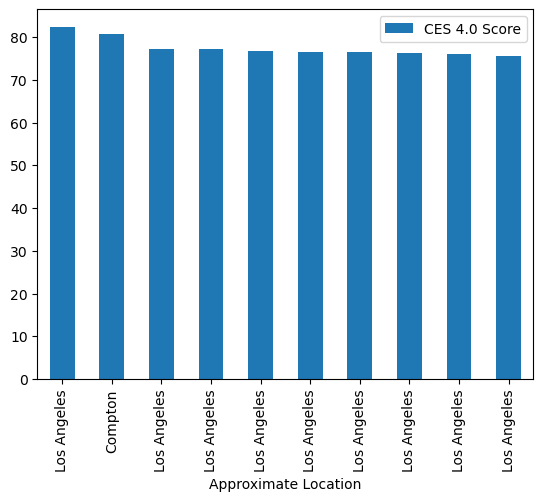

In [30]:
# Visualize the top 10 census tracts, by CES scores 
CES_T2 = CES_T2.sort_values(by='CES 4.0 Score',ascending = False)
CES_T2.head(10).plot.bar(x='Approximate Location',
                            y='CES 4.0 Score'
                          )

In [ ]:
Given the prominence of Los Angeles in the 'approximate location' column, we get no sense of the racial composition; a line graph would show the PCT columns to show the racial split in top 10 tracts; 

In [31]:
import numpy as np

[]

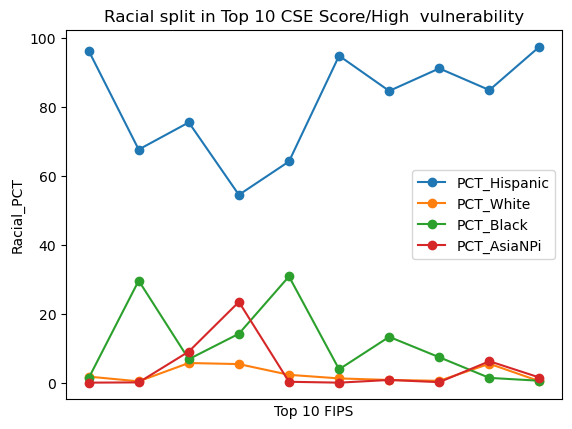

In [32]:
# Sample only the top 10 census tracts 
top_10 = CES_T2.nlargest(10, 'CES 4.0 Score')

# Plotting the line chart
fig, ax = plt.subplots()

# Line chart for each column
for column in ['PCT_Hispanic', 'PCT_White', 'PCT_Black', 'PCT_AsiaNPi']:
    ax.plot(top_10['FIPS'], top_10[column], label=column, marker='o')

# Adding labels and title
ax.set_xlabel('Top 10 FIPS')
ax.set_ylabel('Racial_PCT')
ax.set_title('Racial split in Top 10 CSE Score/High  vulnerability')

# Adding a legend
ax.legend()

# Hiding x-axis labels because FIPS numbers cause clutter on graph)
ax.set_xticks([])

In [ ]:
## Regression Analysis
Comparing the racial split in the top 10 census tracts with the racial compisition of the broader Los Angeles County shown in the image below, it becomes clear that the areas with the highest CalEnviro score - the most environmentally vulnerable and exposed, overrepresent Hispanic and Black populations in particular.
![Race & Ethnicity in Los Angeles County](Data/LA_County_byRace_2021.jpeg)

In [ ]:
**How does PCT_Hispanic, and PCT_Black variable correlate with the CES score?** 

In [ ]:
#begin importing statistical tools 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import linregress

In [ ]:
Correlation between proportion of Black residents 'PCT_Black', and CalEnviro Score 'CES 4.0 Score'

In [34]:
# Remove missing values in the 'PCT_Black' and 'CES 4.0 Score' columns
CES_T2_nonnull1 = CES_T2.dropna(subset=['PCT_Black','CES 4.0 Score'])

P-value: 2.4455385281168334e-15
Slope: 0.26882868487998063
Intercept: 36.411175310968176
R-squared: 0.03165087077253014


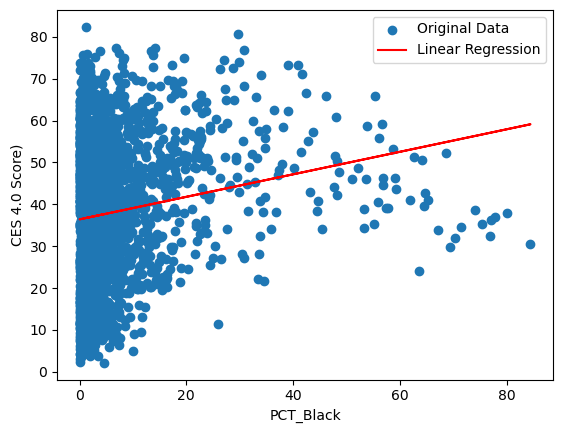

In [35]:
# Define x and y 
x = CES_T2_nonnull1['PCT_Black']
y = CES_T2_nonnull1['CES 4.0 Score']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x,y)

# Print regression parameters
print("P-value:", p_value)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)

# Plot the original data points and the linear regression line
plt.scatter(x, y, label='Original Data')
plt.plot(x, intercept + slope * x, color='red', label='Linear Regression')
plt.xlabel('PCT_Black')
plt.ylabel('CES 4.0 Score)')
plt.legend()
plt.show()

In [ ]:
Correlation between proportion of Hispanic residents 'PCT_Hispanic', and CalEnviro Score 'CES 4.0 Score'

In [36]:
# Remove missing values in the 'PCT_Hispanic' and 'CES 4.0 Score' columns
CES_T2_nonnull2 = CES_T2.dropna(subset=['PCT_Hispanic','CES 4.0 Score'])

P-value: 2.273e-321
Slope: 0.43142193482431357
Intercept: 16.99707409305328
R-squared: 0.5294424723820051


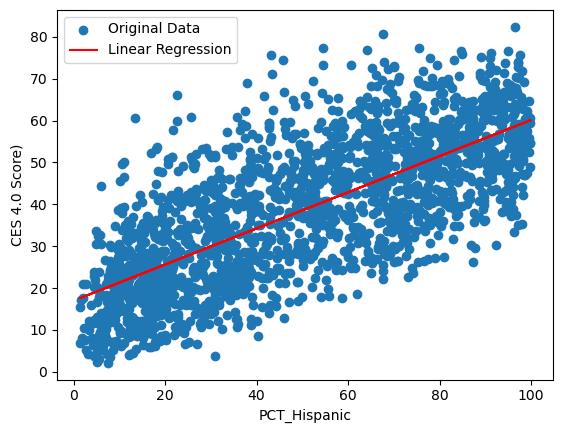

In [37]:
# Define x and y 
x = CES_T2_nonnull2['PCT_Hispanic']
y = CES_T2_nonnull2['CES 4.0 Score']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x,y)

# Print regression parameters
print("P-value:", p_value)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)

# Plot the original data points and the linear regression line
plt.scatter(x, y, label='Original Data')
plt.plot(x, intercept + slope * x, color='red', label='Linear Regression')
plt.xlabel('PCT_Hispanic')
plt.ylabel('CES 4.0 Score)')
plt.legend()
plt.show()

In [ ]:
**Regression Analysis Discussion**
*PCT_Black*
- [ ] Our P-value is very small and less than 0.05 which is deemed to be statistically significant, meaning the null hypothesis - there is no relationship between the CalEnviro score and PCT_Black, should be rejected in such a case. 
- [ ] The slope is 27%, and the 0.03 R-value means that the PCT_Black explains only 3% of the variation in the CES score. However, a low R-squared value may also indicates that the linear model might not be the best fit for your data, and other factors or models should be considered. We may consider other means of assessing the correlation further
*PCT_Hispanic*
- [ ] Similarly, the p-value is very small and statistically significant meaning we can reject the null hypotheses assuming no correlation 
- The slope and R-value for the PCT_Hispanic is even higher; there is a 43% change of y for a one unit increase in PCT_Hispanic, and a high 53% R-squared value (on a scale of 0-100) meaning that there is indeed a stronger relationship between the linear model and the dependent variable, the Cal Enviro score.

## Oil wells and Distance Analysis

In [38]:
# Import plotting tools
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic

In [39]:
# first, we must load the Oil wells data..
dfoil = pd.read_csv('Data/Oil_Wells.csv')

In [40]:
#.. and restrict the wells reviewed to the active ones 
oil_act = dfoil.drop(dfoil[dfoil['WellStatus'] != 'A'].index)
oil_act.head(30)

,X,Y,OBJECTID,DistrictNu,APINumber,BLMWell,DryHole,WellStatus,OperatorNa,CountyName,...,Latitude,Longitude,GISSourceC,LeaseName,Directiona,GISSymbol,LatestUpdate,DataSource,TOOLTIP,NLA_URL
0,-118.365879,33.998254,33,Southern,3700200,N,N,A,Sentinel Peak Resources California LLC,Los Angeles,...,33.998249,-118.365867,gps,BC,N,WF,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Sentinel Peak Resources California L...,navigatela/reports/oil_wells.cfm?pk=03700200
1,-118.383621,34.010842,34,Southern,3700254,N,N,A,Sentinel Peak Resources California LLC,Los Angeles,...,34.010837,-118.383609,gps,TVIC,N,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Sentinel Peak Resources California L...,navigatela/reports/oil_wells.cfm?pk=03700254
2,-118.296514,34.026309,36,Southern,3700302,N,N,A,Sentinel Peak Resources California LLC,Los Angeles,...,34.026304,-118.296502,gps,Jefferson,Y,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Sentinel Peak Resources California L...,navigatela/reports/oil_wells.cfm?pk=03700302
3,-118.320949,34.039605,37,Southern,3700308,N,N,A,Sentinel Peak Resources California LLC,Los Angeles,...,34.039600,-118.320936,gps,Fourth Avenue,Y,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Sentinel Peak Resources California L...,navigatela/reports/oil_wells.cfm?pk=03700308
4,-118.312881,34.032263,40,Southern,3700383,N,N,A,Sentinel Peak Resources California LLC,Los Angeles,...,34.032258,-118.312868,gps,Murphy,Y,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Sentinel Peak Resources California L...,navigatela/reports/oil_wells.cfm?pk=03700383
5,-118.262169,34.036734,41,Southern,3700458,N,N,A,"Nasco Petroleum, L.L.C.",Los Angeles,...,34.036729,-118.262157,gps,L.A. Unit,Y,WF,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,"Operator: Nasco Petroleum, L.L.C.\nAPI No: 037...",navigatela/reports/oil_wells.cfm?pk=03700458
6,-118.262046,34.036657,42,Southern,3700467,N,N,A,"Nasco Petroleum, L.L.C.",Los Angeles,...,34.036652,-118.262034,gps,L.A. Unit Venice FW,Y,WF,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,"Operator: Nasco Petroleum, L.L.C.\nAPI No: 037...",navigatela/reports/oil_wells.cfm?pk=03700467
7,-118.230532,33.763660,43,Southern,3700621,N,N,A,Tidelands Oil Production Co.,Los Angeles,...,33.763655,-118.230520,opr,,N,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Tidelands Oil Production Co.\nAPI No...,navigatela/reports/oil_wells.cfm?pk=03700621
8,-118.109800,34.026507,44,Southern,3700631,N,N,A,Southern California Gas Company,Los Angeles,...,34.026502,-118.109788,gps,Mgs,Y,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,Operator: Southern California Gas Company\nAPI...,navigatela/reports/oil_wells.cfm?pk=03700631
9,-118.231586,33.787280,46,Southern,3701280,N,N,A,"Warren E&P, Inc.",Los Angeles,...,33.787275,-118.231574,gps,NWU,Y,OG,4/27/2018,http://www.conservation.ca.gov/dog/maps/Pages/...,"Operator: Warren E&P, Inc.\nAPI No: 03701280",navigatela/reports/oil_wells.cfm?pk=03701280


# Read the oil gpd and merge with combine 
geoil_act = gpd.GeoDataFrame(oil_act, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(oil_act.Longitude, oil_act.Latitude))
                       
geoil_act.crs
geoil_act.head(10)

In [ ]:
As a group, we were interested in Inglewood as one of our two focus areas, especially with the presence of the Inglewood oil field - a 1,000 acre oil well partially managed by the City of Culver City. Although the site was meant to complete operations by 2026, its operations will be extended 
** What is the distance between other oil wells, and the Inglewood field?**

In [44]:
# Function to calculate distance between two points using network distance
def calculate_distance(G, point1, point2):
    node1 = ox.distance.nearest_nodes(G, point1.x, point1.y)
    node2 = ox.distance.nearest_nodes(G, point2.x, point2.y)
    return ox.distance.great_circle(G, G.nodes[node1]['y'], G.nodes[node1]['x'], G.nodes[node2]['y'], G.nodes[node2]['x'])

# Central location (replace with your own central location)
central_location = "Inglewood Oil Field"
G = ox.graph.graph_from_address(central_location, network_type='all')

# Calculate distance from each oil well to the central location
central_point = geoil_act['geometry'][0]
geoil_act['Distance_to_Central'] = geoil_act['geometry'].apply(lambda x: calculate_distance(G, x, central_point))

# Display the resulting DataFrame
print(geoil_act[['OBJECTID', 'Distance_to_Central']])
geoil_act['Distance_to_Central'].head(10)

      OBJECTID                                Distance_to_Central
0           33  [-114.41561943968355, -304.4954746204147, -325...
1           34  [-114.42860079891011, -304.50845583140136, -32...
2           36  [-114.41561943968355, -304.4954746204147, -325...
3           37  [-114.4278881146036, -304.5077425329122, -325....
4           40  [-114.41561943968355, -304.4954746204147, -325...
...        ...                                                ...
3866     22739  [-114.43858214410079, -304.5184366030414, -325...
3867     22753  [-114.42888465790844, -304.5087396325353, -325...
3868     22756  [-114.42888465790844, -304.5087396325353, -325...
3869     22769  [-114.41561943968355, -304.4954746204147, -325...
3870     22770  [-114.41561943968355, -304.4954746204147, -325...

[3871 rows x 2 columns]


0    [-114.41561943968355, -304.4954746204147, -325...
1    [-114.42860079891011, -304.50845583140136, -32...
2    [-114.41561943968355, -304.4954746204147, -325...
3    [-114.4278881146036, -304.5077425329122, -325....
4    [-114.41561943968355, -304.4954746204147, -325...
5    [-114.41561943968355, -304.4954746204147, -325...
6    [-114.41561943968355, -304.4954746204147, -325...
7    [-114.42888465790844, -304.5087396325353, -325...
8    [-114.41561943968355, -304.4954746204147, -325...
9    [-114.42888465790844, -304.5087396325353, -325...
Name: Distance_to_Central, dtype: object

For upcoming assignments, I hope to build off of this analysis, rectifying the distance_to_central calculation, and conducting autocorrelation analysis for the oil wells in Inglewood and Beverly Hills. 